In [170]:
import gymnasium as gym
import collections
import numpy as np
import matplotlib.pyplot as plt

ENV_NAME = "FrozenLake-v1"
GAMMA = 0.9

In [171]:
env = gym.make(ENV_NAME, is_slippery = False)

# print the state space and action space
print(f'state size {env.observation_space.n}')
print(f'action_size {env.action_space.n}')

nS = env.observation_space.n
nA = env.action_space.n

state size 16
action_size 4


### Initial Policy

Play 10 episodes with the random policy

In [172]:
# Initiate a random policy
policy = np.ones([nS, nA]) / nA

In [173]:
for epi in range(10):
    
    s = env.reset()[0]
    done, term = False, False
    score = []
    
    while not any([term, done]):
        # Take an action based on random policy
        a = np.argmax(policy[s])
        s_, r, done , term, _ = env.step(a)
        score.append(r)
        s = s_
    print(np.sum(score))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


### Policy Evaluation

$v_\pi(s) = \sum_{a} \pi(a|s) \sum_{s',r} p(s',r|s,a)[r+\gamma*v_\pi(s')]$

In [174]:
def update_value(env, policy): 
    theta=1e-8
    gamma = 1
    V = np.zeros(nS)
    iter = 0
    while True:
        delta = 0
        iter += 1
        for s in range(nS):
            Vs = 0
            for a, pi_a_s in enumerate(policy[s]):
                for ps_sa, s_, reward, done in env.unwrapped.P[s][a]:
                    Vs += pi_a_s * ps_sa * (reward + gamma * V[s_])
            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs
        if delta < theta:
            break
        
    return V#, iter

Build the value function for initial random policy

In [175]:
V = update_value(env, policy)
V_ini = np.copy(V)

#print(f'Convergence in {iterations = }')
print(np.reshape(V_ini, (4,4)))

[[0.01393977 0.01163091 0.02095297 0.01047648]
 [0.01624865 0.         0.04075153 0.        ]
 [0.03480619 0.08816993 0.14205316 0.        ]
 [0.         0.17582037 0.43929118 0.        ]]


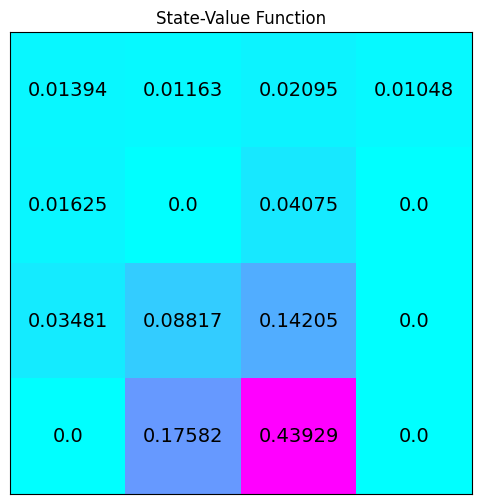

In [176]:

V_sq = np.reshape(V_ini, (4,4))
z_min, z_max = V_sq.min(), V_sq.max()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
im = ax.imshow(V_sq, cmap='cool', vmin = z_min, vmax = z_max,)

for (j,i),label in np.ndenumerate(V_sq):
    ax.text(i, j, np.round(label, 5), ha='center', va='center', fontsize=14)

plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
plt.title('State-Value Function')
plt.show()


### Obtain $q_\pi$ from $v_\pi$

$q_\pi(s,a) = \sum_{s',r} p(s',r|s,a)[r+\gamma*v_\pi(s')]$

In [177]:
def q_from_v(env, V, s, gamma=1):
    q = np.zeros(nA)
    for a in range(nA):
        for prob, s_, reward, done in env.P[s][a]:
            q[a] += prob * (reward + gamma * V[s_])
    return q

In [178]:
Q = np.zeros([nS, nA])
for s in range(nS):
    Q[s] = q_from_v(env, V, s)
print("Action-Value Function:")
print(Q)

Action-Value Function:
[[0.01393977 0.01624865 0.01163091 0.01393977]
 [0.01393977 0.         0.02095297 0.01163091]
 [0.01163091 0.04075153 0.01047648 0.02095297]
 [0.02095297 0.         0.01047648 0.01047648]
 [0.01624865 0.03480619 0.         0.01393977]
 [0.         0.         0.         0.        ]
 [0.         0.14205316 0.         0.02095297]
 [0.         0.         0.         0.        ]
 [0.03480619 0.         0.08816993 0.01624865]
 [0.03480619 0.17582037 0.14205316 0.        ]
 [0.08816993 0.43929118 0.         0.04075153]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.17582037 0.43929118 0.08816993]
 [0.17582037 0.43929118 1.         0.14205316]
 [0.         0.         0.         0.        ]]


### Policy Improvement

$\pi'(s) = argmax_{a}q_\pi(s,a)$

In [185]:
policy = np.zeros([nS, nA]) / nA

for s in range(nS):
    q = Q[s]
    # OPTION 1: construct a deterministic policy 
    #policy[s][np.argmax(q)] = 1

    # OPTION 2: construct a stochastic policy that puts equal probability on maximizing actions
    best_a = np.argwhere(q==np.max(q)).flatten()
    policy[s] = np.sum([np.eye(nA)[i] for i in best_a], axis=0)/len(best_a)

In [186]:
print("Improved policy")
print(policy)

Improved policy
[[0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   0.   1.   0.  ]
 [0.25 0.25 0.25 0.25]]


### Policy Iteration

In [181]:
n = 0


while True:
    
    delta = 0
    V = update_value(env, policy)
    V_new = np.copy(V)
    
    Q = np.zeros([nS, nA])
    for s in range(nS):
        Q[s] = q_from_v(env, V, s)
        
    policy = np.zeros([nS, nA]) / nA

    for s in range(nS):
    #s = 0
        q = Q[s]

        # OPTION 1: construct a deterministic policy 
        #policy[s][np.argmax(q)] = 1

        # OPTION 2: construct a stochastic policy that puts equal probability on maximizing actions
        
        best_a = np.argwhere(q==np.max(q)).flatten()
        policy[s] = np.sum([np.eye(nA)[i] for i in best_a], axis=0)/len(best_a)
    
    delta = np.max(np.abs(V_new - V_ini))
    V_ini = V_new.copy()
    if delta < 1e-3:
        
        break
    
    n+=1
    

In [182]:
np.reshape(V_ini, (4,4))

array([[0.99999956, 0.99999956, 0.99999959, 0.99999957],
       [0.99999959, 0.        , 0.99999966, 0.        ],
       [0.99999965, 0.99999971, 0.99999973, 0.        ],
       [0.        , 0.99999977, 0.99999983, 0.        ]])

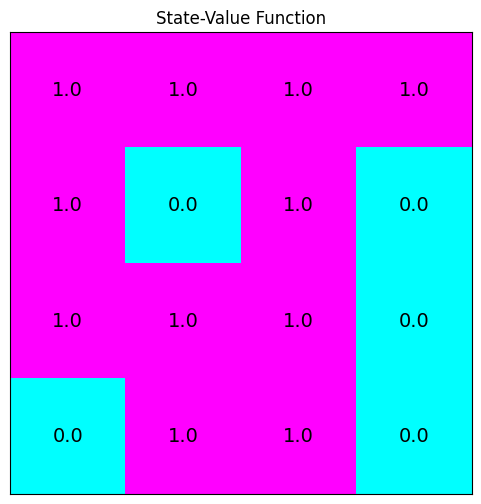

In [183]:
V_sq = np.reshape(V_ini, (4,4))
z_min, z_max = V_sq.min(), V_sq.max()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
im = ax.imshow(V_sq, cmap='cool', vmin = z_min, vmax = z_max,)

for (j,i),label in np.ndenumerate(V_sq):
    ax.text(i, j, np.round(label, 5), ha='center', va='center', fontsize=14)

plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
plt.title('State-Value Function')
plt.show()

In [184]:
for epi in range(10):
    
    s = env.reset()[0]
    done, term = False, False
    score = []
    
    while not any([term, done]):
        a = np.argmax(policy[s])
        s_, r, done , term, _ = env.step(a)
        
        score.append(r)
        s = s_
    print(np.sum(score))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
